In [70]:
import nemo.collections.asr as nemo_asr
import glob
import librosa
import soundfile
import pydub
import torch
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import numpy as np

In [30]:
classifier = nemo_asr.models.EncDecClassificationModel.from_pretrained("commandrecognition_en_matchboxnet3x2x64_v2").to('cpu').eval()
labels = classifier.to_config_dict()['labels_full']

[NeMo I 2022-12-14 11:59:59 cloud:56] Found existing object /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo.
[NeMo I 2022-12-14 11:59:59 cloud:62] Re-using file from: /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo
[NeMo I 2022-12-14 11:59:59 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-14 11:59:59 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    labels:
    - visual
    - wow
    - learn
    - backward
    - dog
    - two
    - left
    - happy
    - nine
    - go
    - up
    - bed
    - stop
    - one
    - zero
    - tree
    - seven
    - 'on'
    - four
    - bird
    - right
    - eight
    - 'no'
    - six
    - forward
    - house
    - marvin
    - sheila
    - five
    - 'off'
    - three
    - down
    - cat
    - follow
    - 'yes'
    batch_size: 128
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      shift:
        prob: 1.0
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 1.0
        min_level: -90
        max_level: -46


[NeMo I 2022-12-14 11:59:59 save_restore_connector:243] Model EncDecClassificationModel was successfully restored from /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo.


In [87]:
filenames=[]
records = []
embeds = []
for f in glob.glob("train_samples/*/*.wav"):
    label = f.split('/')[1]
    y, _ = librosa.load(f, sr=16_000)
    input_signal = torch.FloatTensor([y])
    input_signal_length = torch.IntTensor([len(y)])
    #preprocessed, length =classifier.preprocessor.forward(input_signal=input_signal, length=input_signal_length)
    #res = classifier.encoder.forward(audio_signal=preprocessed, length=length)
    res = classifier.forward(input_signal=input_signal, input_signal_length=input_signal_length)
    filenames.append(f)
    records.append(label)
    embeds.append(res.detach().numpy()[0])

In [88]:
df = pd.DataFrame(filenames, columns=['filepath'])
df['label'] = records


In [89]:
d = pd.DataFrame(np.array(embeds), columns=[f'feat_{i}' for i in range(35)])

In [90]:
pd.concat([df, d], axis=1)

,filepath,label,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34
0,train_samples/gingivitis/audio1_0.wav,gingivitis,0.690715,-4.221004,-1.654710,-0.213699,0.190082,2.069187,1.759605,-4.158026,...,-2.399840,1.280642,0.589114,3.927298,-3.728300,1.578254,-1.849225,-0.685296,-0.768198,5.254896
1,train_samples/gingivitis/audio1_1.wav,gingivitis,4.522921,-5.546092,-0.402156,0.302269,-0.811188,0.101680,6.890267,-2.129440,...,-3.936670,1.061645,1.908728,6.366740,-1.767791,0.565201,-3.706400,-0.059594,-3.902491,2.063842
2,train_samples/gingivitis/audio1_2.wav,gingivitis,4.691451,-5.740780,0.082298,0.735041,-1.194591,-1.127305,5.986703,-4.618463,...,-2.138952,3.764611,1.700915,4.632336,-1.920288,-1.207987,-3.308685,-2.394087,2.164444,4.419206
3,train_samples/gingivitis/audio1_3.wav,gingivitis,3.991402,-3.929276,-0.493782,0.965060,-0.601185,0.996684,4.376258,-3.767560,...,-2.473560,1.254641,0.994405,4.780548,-1.698319,0.075275,-2.212385,-2.018842,-2.171567,3.745478
4,train_samples/gingivitis/audio1_4.wav,gingivitis,2.707101,-3.071803,-0.607576,0.771648,-1.247529,-0.501678,5.623439,-3.056743,...,-3.338178,0.192847,1.282300,6.227386,-1.110852,0.758856,-1.481148,-1.635907,-1.343281,2.121866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,train_samples/margin/8gv8LPfKDPM_0.wav,margin,4.374311,-3.080450,-0.031912,2.475593,0.711325,-1.072137,1.846311,1.814691,...,-1.806147,4.030399,-1.666097,3.654263,-0.912240,1.040068,-0.632949,-5.379098,-0.176115,-2.337691
206,train_samples/lingual/bXV0xiv1H58_0.wav,lingual,1.501221,6.712025,3.786906,5.772694,0.112045,-2.067027,0.373709,-4.280031,...,-2.236484,2.710642,-2.111450,-3.165634,-0.806044,-2.312998,0.674685,-4.325404,-0.096284,1.455671
207,train_samples/lingual/bXV0xiv1H58_1.wav,lingual,7.332437,-1.342137,0.276244,3.301267,1.168844,-2.630372,-1.328364,1.439609,...,-5.373462,7.158456,0.729216,0.175180,-3.662781,1.836749,0.937970,-6.877767,-0.234039,-2.580319
208,train_samples/lingual/bXV0xiv1H58_2.wav,lingual,2.278311,-1.056446,1.515101,4.365111,-0.407093,-0.821510,-0.499962,-0.124053,...,-3.989098,2.070316,3.331068,-0.492212,-2.855946,0.453305,0.361825,-4.375628,1.033310,-1.811916


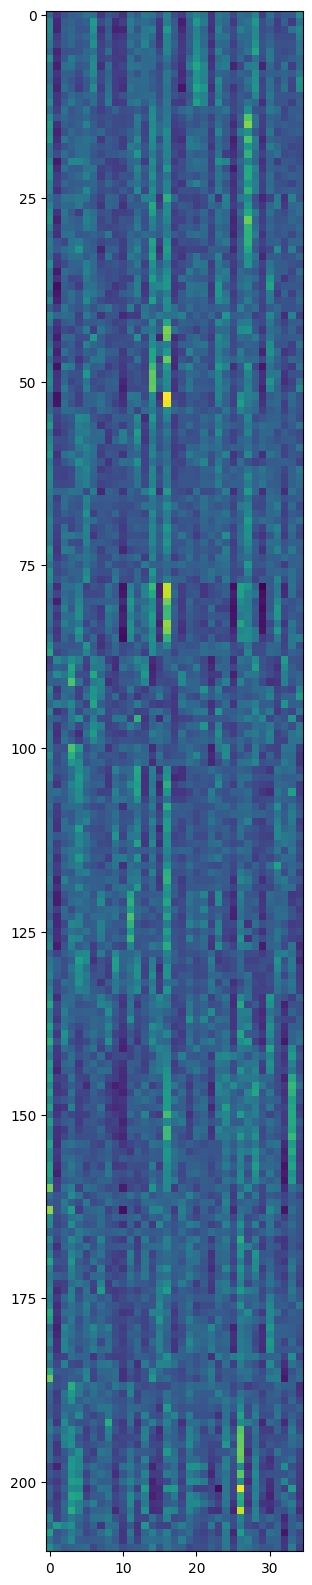

In [91]:
plt.figure(figsize=(8,20))
plt.imshow(np.array(embeds))